# Comprehensive Signal Analysis: Time-Domain and Frequency-Domain Techniques for Signal Processing on netra_50msps.dat

In [24]:
import numpy as np
from numpy import sin, cos, pi
from scipy.fftpack import fft, fftfreq, ifft
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.fft import fft
from scipy.signal import spectrogram
import scipy.signal as signal
from scipy.signal.windows import hamming
from scipy.signal import resample  # Importing the resample function
import scipy.signal

print('Imported successfully')

Imported successfully


# visualize NETRA DATA

Number of samples: 3330
Duration of the signal: 0.000067 seconds (0.07 milliseconds)


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


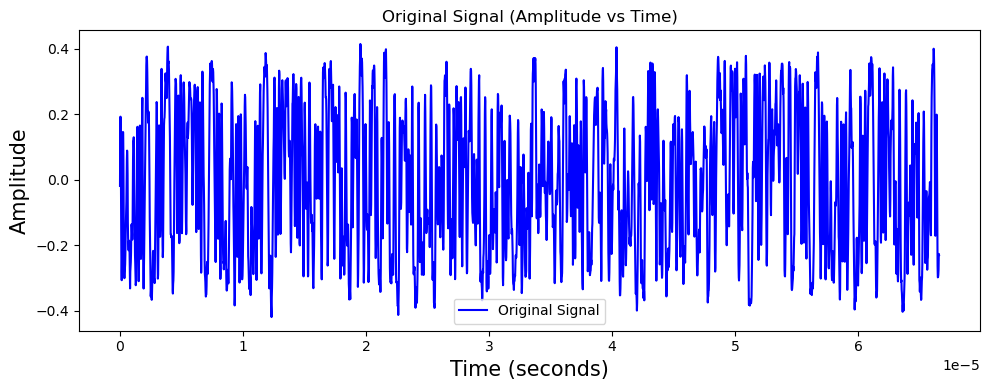

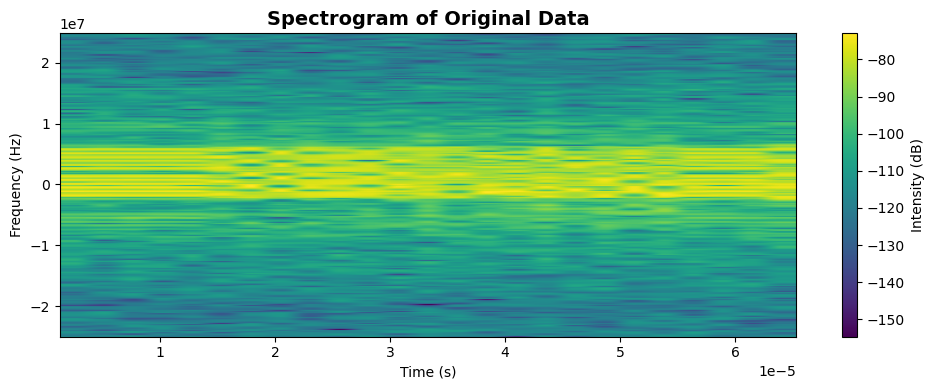

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_signal_and_spectrogram(file_path, sampling_rate=50e6):
    """
    Reads complex data from a .dat file, plots the time-domain signal and its spectrogram,
    and returns the signal data, time array, number of samples, and signal duration.

    Parameters:
    - file_path: str, path to the .dat file.
    - sampling_rate: float, sampling frequency in Hz (default is 50e6 for 50Msps).

    Returns:
    - netra_data: np.ndarray, the complex signal data.
    - time: np.ndarray, time array corresponding to the signal.
    - num_samples: int, total number of samples.
    - duration_sec: float, duration of the signal in seconds.
    """

    # Step 1: Read the data
    with open(file_path, "rb") as f:
        netra_data = np.fromfile(f, dtype=np.complex64)

    # Step 2: Create time array
    time = np.arange(0, len(netra_data)) / sampling_rate

    # Step 3: Compute number of samples and duration
    num_samples = len(netra_data)
    duration_sec = num_samples / sampling_rate
    duration_ms = duration_sec * 1000  # convert to milliseconds

    # Step 4: Print sample info
    print(f"Number of samples: {num_samples}")
    print(f"Duration of the signal: {duration_sec:.6f} seconds ({duration_ms:.2f} milliseconds)")

    # Step 5: Plot the time-domain signal
    plt.figure(figsize=(10, 4))
    plt.plot(time, netra_data, label="Original Signal", color='blue')
    plt.title("Original Signal (Amplitude vs Time)")
    plt.xlabel("Time (seconds)", fontsize=15)
    plt.ylabel("Amplitude", fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Step 6: Plot spectrogram
    plt.figure(figsize=(10, 4))
    plt.specgram(netra_data, Fs=sampling_rate)
    plt.title('Spectrogram of Original Data', fontsize=14, fontweight='bold')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Intensity (dB)")
    plt.tight_layout()
    plt.show()

    return netra_data, time, num_samples, duration_sec
samplefile = "/home/sandeep/Downloads/netra_50msps.dat"
netra_data, time, num_samples, duration = plot_signal_and_spectrogram(samplefile)


# Computes and plots the FFT spectrum of netra data

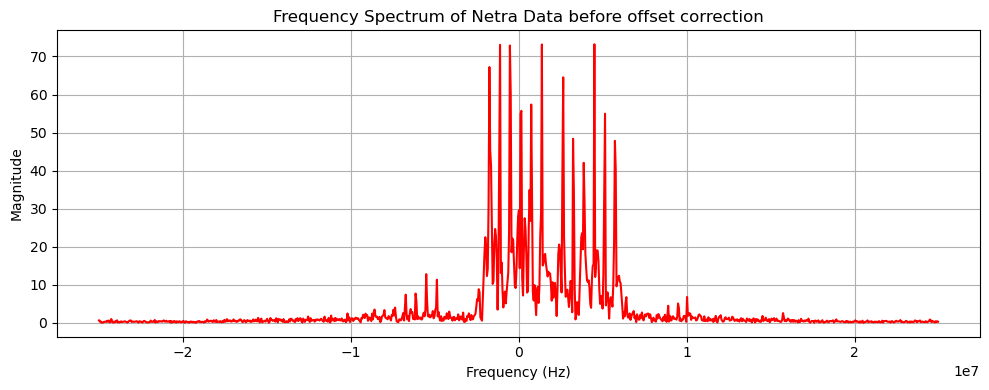

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fft_spectrum(signal, sampling_rate=50e6, N_fft=1024, title_suffix="before offset correction"):
    """
    Computes and plots the FFT spectrum of the given signal.

    Parameters:
    - signal: np.ndarray, the input complex signal.
    - sampling_rate: float, sampling frequency in Hz.
    - N_fft: int, FFT size (default is 1024).
    - title_suffix: str, suffix to add to the plot title for context.
    """

    # Compute FFT and frequency axis
    signal_fft = np.fft.fftshift(np.fft.fft(signal, N_fft))
    freqs = np.fft.fftshift(np.fft.fftfreq(N_fft, d=1/sampling_rate))

    # Plot the FFT magnitude
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, np.abs(signal_fft), color='red')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(f'Frequency Spectrum of Netra Data {title_suffix}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_fft_spectrum(netra_data, sampling_rate=50e6, N_fft=1024, title_suffix="before offset correction")


# Estimate frequency offset of netra data

In [7]:
import numpy as np
from scipy.signal import welch, hamming

class DroneSignalProcessor:
    def __init__(self, debug=True):
        self.debug = debug

    @staticmethod
    def consecutive(data, stepsize=1):
        """Group consecutive elements based on a step size."""
        return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)

    def estimate_offset(self, y, Fs, packet_type="droneid"):
        """Estimate the frequency offset in the signal."""
        nfft_welch = 2048  # FFT size for PSD calculation

        if len(y) < nfft_welch:
            return None, False

        # Apply Hamming window to the signal
        window = hamming(len(y))
        y = y * window

        # Calculate Power Spectral Density (PSD)
        f, Pxx_den = welch(y, Fs, nfft=nfft_welch, return_onesided=False)
        Pxx_den = np.fft.fftshift(Pxx_den)
        f = np.fft.fftshift(f)

        # Add a fake DC carrier to distinguish signal components
        Pxx_den[nfft_welch // 2 - 10:nfft_welch // 2 + 10] = 1.1 * Pxx_den.mean()

        # Identify candidate frequency bands
        candidate_bands = self.consecutive(np.where(Pxx_den > 1.1 * Pxx_den.mean())[0])

        band_found = False
        offset = 0.0

        for band in candidate_bands:
            start = band[0] - nfft_welch / 2
            end = band[-1] - nfft_welch / 2
            bw = (end - start) * (Fs / nfft_welch)
            fend = start * Fs / nfft_welch
            fstart = end * Fs / nfft_welch

            if self.debug:
                print(f"Candidate band fstart: {fstart:.2f}, fend: {fend:.2f}, bw: {bw / 1e6:.2f} MHz")

            # Match candidate bands based on packet type
            if packet_type == "droneid" and (8e6 < bw < 11e6):
                offset = fstart - 0.5 * bw
                band_found = True
                break
            elif packet_type == "c2" and (1.2e6 < bw < 1.95e6):
                offset = fstart - 0.5 * bw
                band_found = True
                break
            elif packet_type == "video" and (18e6 < bw < 22e6):
                offset = fstart - 0.5 * bw
                band_found = True
                break

        if self.debug:
            print(f"Offset found: {offset / 1000:.2f} kHz")
        return offset, band_found

# Example Usage
sampling_rate = 50e6  # 50 Msps
processor = DroneSignalProcessor(debug=True)

# Estimate the offset frequency
offset, band_found = processor.estimate_offset(netra_data, sampling_rate, packet_type="droneid")

if band_found:
    print(f"Final Offset Frequency: {offset / 1e3:.2f} kHz")
else:
    print("No suitable band found.")


Candidate band fstart: 6176757.81, fend: -2294921.88, bw: 8.47 MHz
Offset found: 1940.92 kHz
Final Offset Frequency: 1940.92 kHz


/tmp/ipykernel_143085/2644440055.py:21: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = hamming(len(y))


# Correction of Offset frequency 

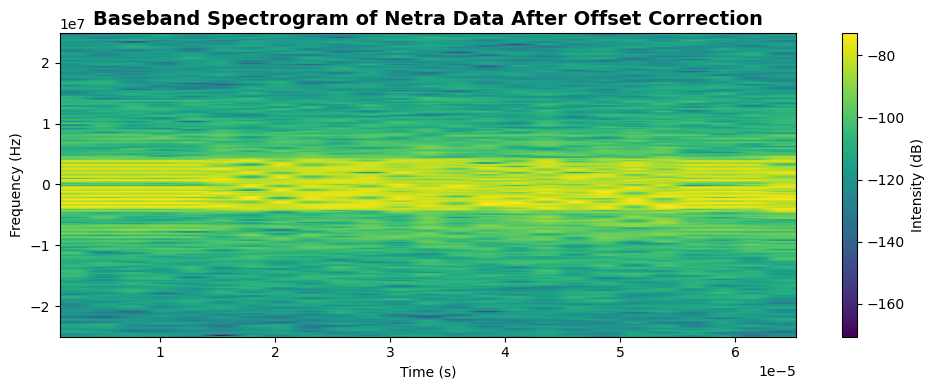

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def apply_offset_correction_and_plot_spectrogram(signal, time, offset_freq, sampling_rate=50e6):
    """
    Applies frequency offset correction to a signal and plots the corrected spectrogram.

    Parameters:
    - signal: np.ndarray, complex signal to correct.
    - time: np.ndarray, time array corresponding to the signal.
    - offset_freq: float, frequency offset to correct (in Hz).
    - sampling_rate: float, sampling frequency (Hz).
    
    Returns:
    - corrected_signal: np.ndarray, signal after offset correction.
    """

    # Apply frequency offset correction
    corrected_signal = signal * np.exp(-1j * 2 * np.pi * offset_freq * time)

    # Plot spectrogram of corrected signal
    plt.figure(figsize=(10, 4))
    plt.specgram(corrected_signal, Fs=sampling_rate)
    plt.title('Baseband Spectrogram of Netra Data After Offset Correction', fontsize=14, fontweight='bold')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Intensity (dB)")
    plt.tight_layout()
    plt.show()

    return corrected_signal
offset_freq = 1.94092e6  # Detected frequency offset in Hz (1.94 MHz)
data = apply_offset_correction_and_plot_spectrogram(netra_data, time, offset_freq, sampling_rate=50e6)


# Power spectral density of netra data after offset frequency correction

/tmp/ipykernel_143085/2284826129.py:26: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = hamming(len(signal))


Mean PSD Value: 8.20e-10 V^2/Hz


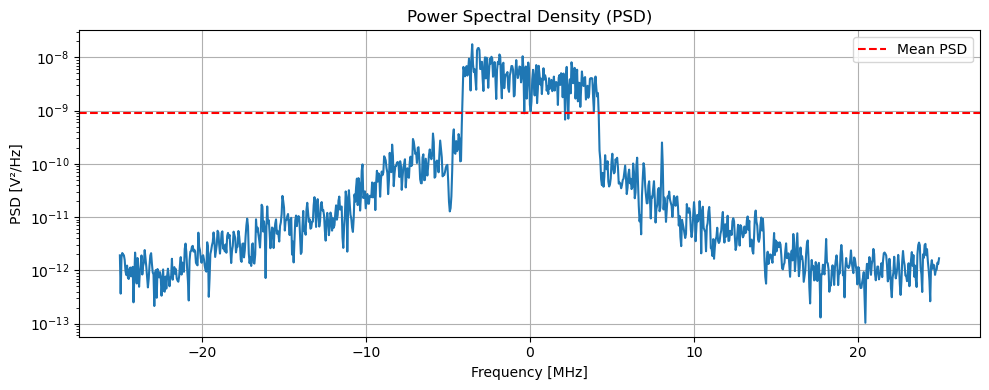

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, hamming

def compute_and_plot_psd(signal, sampling_rate=50e6, nfft=1024):
    """
    Computes and plots the Power Spectral Density (PSD) of a signal using Welch's method.

    Parameters:
    - signal: np.ndarray, complex signal after offset correction.
    - sampling_rate: float, sampling frequency in Hz (default 50e6).
    - nfft: int, number of FFT points for Welch's method.

    Returns:
    - f_shifted: np.ndarray, shifted frequency bins (in Hz).
    - psd_shifted: np.ndarray, shifted PSD values.
    - mean_psd: float, mean PSD value.
    """

    # Check signal length
    if len(signal) < nfft:
        print("Insufficient data length for Welch's method.")
        return None, None, None

    # Apply Hamming window
    window = hamming(len(signal))
    windowed_signal = signal * window

    # Compute PSD using Welch’s method
    f, Pxx_den = welch(
        windowed_signal, fs=sampling_rate, nperseg=nfft, return_onesided=False
    )

    # Shift PSD and frequency bins for symmetric spectrum
    psd_shifted = np.fft.fftshift(Pxx_den)
    f_shifted = np.fft.fftshift(f)

    # Calculate mean PSD value
    mean_psd = np.mean(psd_shifted)
    print(f"Mean PSD Value: {mean_psd:.2e} V^2/Hz")

    # Plot the PSD
    plt.figure(figsize=(10, 4))
    plt.semilogy(f_shifted / 1e6, psd_shifted)
    plt.axhline(1.1 * mean_psd, color='r', linestyle='--', label="Mean PSD")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD [V²/Hz]")
    plt.title("Power Spectral Density (PSD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return f_shifted, psd_shifted, mean_psd
f_psd, psd_vals, mean_psd_val = compute_and_plot_psd(data, sampling_rate=50e6, nfft=1024)


# Frequency spectrum of netra data after offset frequency correction

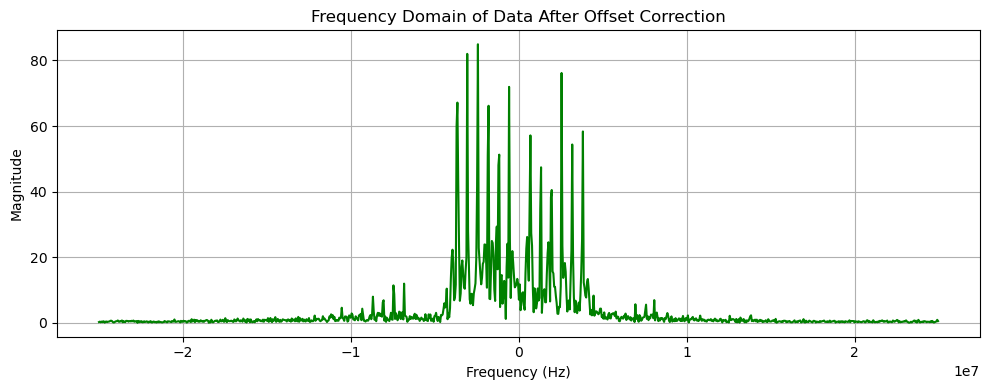

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fft_after_offset_correction(signal, sampling_rate=50e6, N_fft=1024):
    """
    Computes and plots the FFT magnitude of a signal after offset correction.

    Parameters:
    - signal: np.ndarray, complex baseband signal after frequency offset correction.
    - sampling_rate: float, sampling rate in Hz (default: 50e6).
    - N_fft: int, number of FFT points (default: 1024).
    """

    # Compute FFT and frequency bins
    fft_vals = np.fft.fftshift(np.fft.fft(signal, N_fft))
    freqs = np.fft.fftshift(np.fft.fftfreq(N_fft, 1 / sampling_rate))

    # Plot the magnitude spectrum
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, np.abs(fft_vals), color='green')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Frequency Domain of Data After Offset Correction')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_fft_after_offset_correction(data, sampling_rate=50e6, N_fft=1024)


# Magnitude and phase response of netra data after offset frequency correction

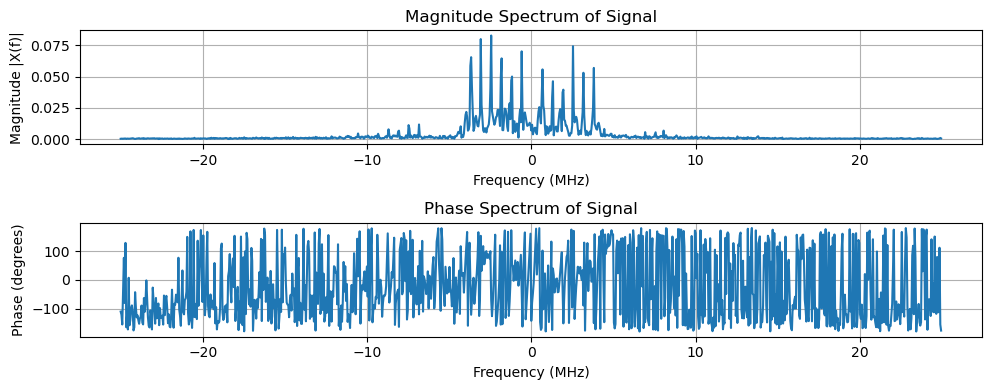

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_magnitude_phase_spectrum(signal, sampling_rate=50e6, fft_size=1024):
    """
    Computes and plots the magnitude and phase spectrum of a signal using FFT.

    Parameters:
    - signal: np.ndarray, complex time-domain signal.
    - sampling_rate: float, sampling rate in Hz (default: 50e6).
    - fft_size: int, FFT size (default: 1024).
    """

    # Compute FFT with normalization and shift
    X = np.fft.fftshift(np.fft.fft(signal, fft_size)) / fft_size

    # Frequency axis setup
    df = sampling_rate / fft_size
    sample_index = np.arange(-fft_size // 2, fft_size // 2)
    f = sample_index * df / 1e6  # Convert Hz to MHz for plotting

    # Plot magnitude and phase
    plt.figure(figsize=(10, 4))

    # Magnitude spectrum
    plt.subplot(2, 1, 1)
    plt.plot(f, np.abs(X))
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Magnitude |X(f)|')
    plt.title('Magnitude Spectrum of Signal')
    plt.grid(True)

    # Phase spectrum
    plt.subplot(2, 1, 2)
    phase = np.angle(X, deg=True)
    plt.plot(f, phase)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Phase (degrees)')
    plt.title('Phase Spectrum of Signal')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_magnitude_phase_spectrum(data, sampling_rate=50e6, fft_size=1024)


# Applying DFT Low pass filter on netra data after offset frequency

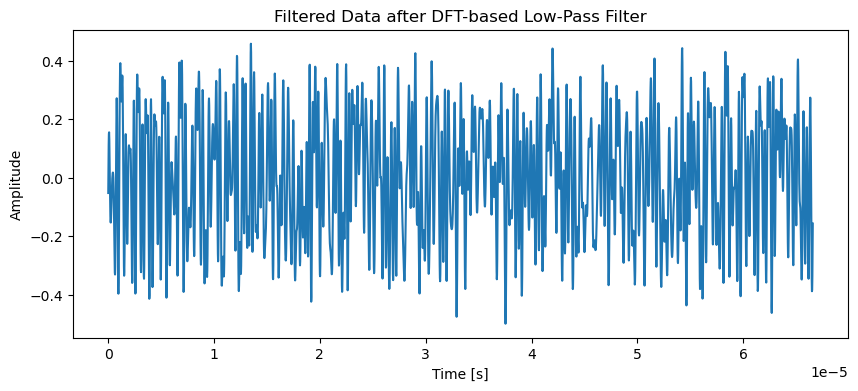

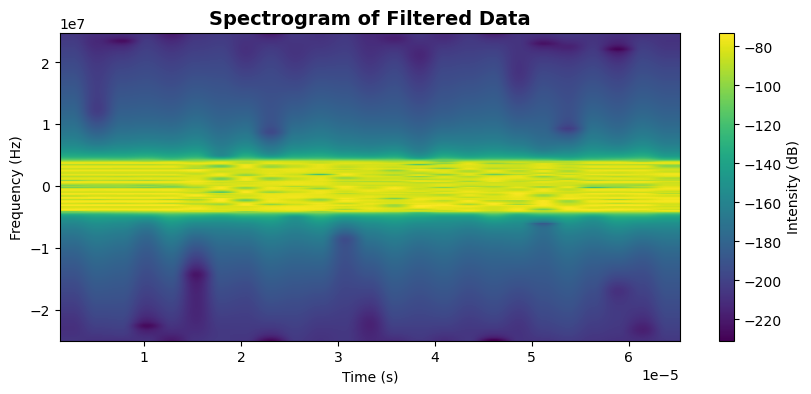

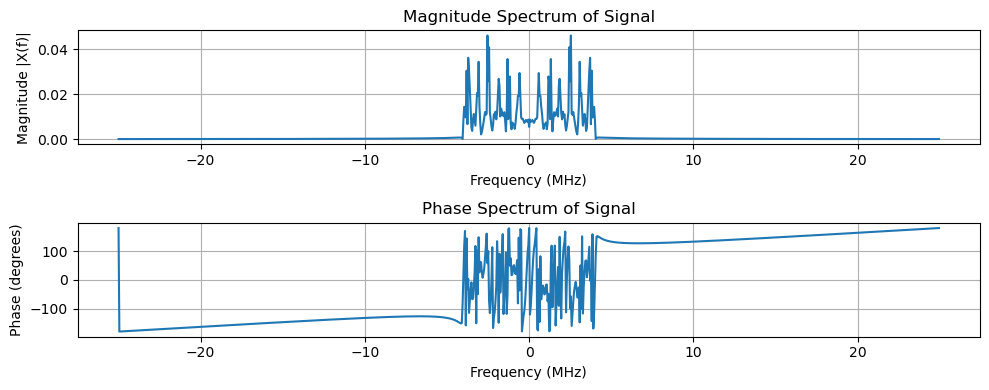

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

def dft_filter(signal: np.ndarray, cutoff: float, sample_rate: float):
    """
    Apply a DFT-based low-pass filter to the signal.
    
    Parameters:
        signal (np.ndarray): Input signal data.
        cutoff (float): Cutoff frequency for the filter in Hz.
        sample_rate (float): Sampling rate in Hz.
    
    Returns:
        signal_filtered (np.ndarray): The filtered signal.
    """
    # Compute the DFT
    dft = np.fft.fft(signal)
    
    # Frequency bins
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)
    
    # Low-pass filter mask
    filter_mask = np.abs(freqs) < cutoff
    
    # Apply the mask
    dft_filtered = dft * filter_mask
    
    # Inverse FFT to get time-domain signal
    signal_filtered = np.fft.ifft(dft_filtered)
    
    return signal_filtered

# Parameters
cutoff_freq = 4e6  # Cutoff frequency in Hz (e.g., 4 MHz)
fs = 50e6          # Sampling rate (50 MHz)

# Apply DFT-based low-pass filter
filtered_data_dft = dft_filter(data, cutoff=cutoff_freq, sample_rate=fs)

# Plot the filtered signal (time-domain)
plt.figure(figsize=(10, 4))
plt.plot(time, np.real(filtered_data_dft))
plt.title("Filtered Data after DFT-based Low-Pass Filter")
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

# Compute and plot spectrogram for the filtered data
plt.figure(figsize=(10, 4))
plt.specgram(filtered_data_dft, Fs=fs)
plt.title('Spectrogram of Filtered Data', fontsize=14, fontweight='bold')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Intensity (dB)")
plt.show()

# Compute and plot the frequency spectrum of the filtered signal
plot_magnitude_phase_spectrum(np.real(filtered_data_dft), sampling_rate=fs, fft_size=1024)


# Compute the Power Spectral Density (PSD) of the filtered data using Welch's method

Mean PSD Value: 3.98e-10 V^2/Hz


/tmp/ipykernel_143085/3751432112.py:23: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = hamming(len(filtered_data))


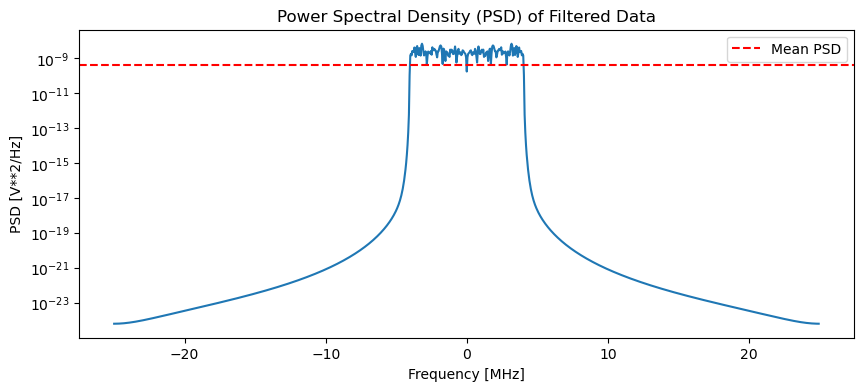

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, hamming

def compute_psd(filtered_data, fs, nfft_welch=1024):
    """
    Compute the Power Spectral Density (PSD) of the filtered data using Welch's method.
    
    Parameters:
        filtered_data (np.ndarray): The filtered signal data.
        fs (float): Sampling frequency in Hz.
        nfft_welch (int): Number of FFT points for Welch's method (default is 1024).
        
    Returns:
        None
    """
    # Ensure data length is sufficient for Welch's method
    if len(filtered_data) < nfft_welch:
        print("Insufficient data length for Welch's method")
        return

    # Apply Hamming window
    window = hamming(len(filtered_data))
    filtered_data_windowed = np.real(filtered_data) * window  # Using the real part of the filtered data

    # Calculate PSD using Welch's method
    f, Pxx_den = welch(
        filtered_data_windowed, fs=fs, nperseg=nfft_welch, return_onesided=False
    )

    # Shift frequency and PSD for negative frequencies
    Pxx_den_shifted = np.fft.fftshift(Pxx_den)
    f_shifted = np.fft.fftshift(f)

    # Calculate the mean PSD value
    filtered_mean_psd_value = np.mean(Pxx_den_shifted)
    print(f"Mean PSD Value: {filtered_mean_psd_value:.2e} V^2/Hz")

    # Plot the PSD
    plt.figure(figsize=(10, 4))
    plt.semilogy(f_shifted / 1e6, Pxx_den_shifted)  # Convert frequency to MHz
    plt.axhline(1.1 * Pxx_den_shifted.mean(), color='r', linestyle='--', label="Mean PSD")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD [V**2/Hz]")
    plt.title("Power Spectral Density (PSD) of Filtered Data")
    plt.legend()
    plt.show()

# Example usage
# Assuming 'filtered_data' is the filtered signal data (after applying the DFT filter)
# and 'fs' is the sampling frequency
compute_psd(filtered_data_dft, fs)


# Compute SNR

Mean PSD Value: 7.77e-10 V^2/Hz
SNR: 26.06 dB


/tmp/ipykernel_143085/2371156665.py:27: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = hamming(len(data))


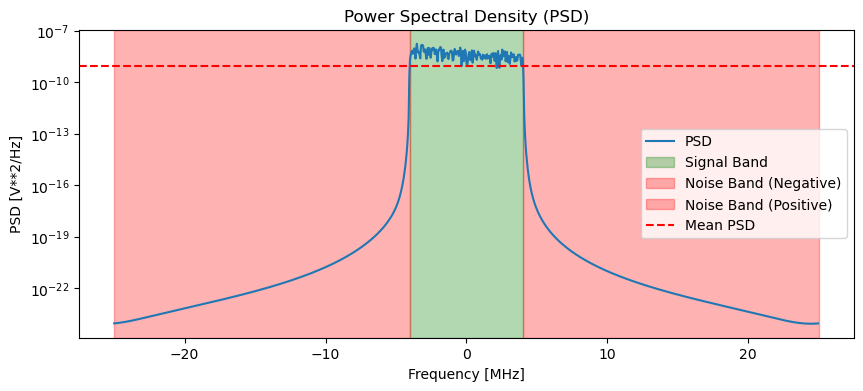

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, hamming
from scipy.integrate import simps

def calculate_and_plot_psd_with_snr(data, fs, nfft_welch, signal_band, noise_band_neg, noise_band_pos):
    """
    Calculate and plot the Power Spectral Density (PSD) and compute the SNR.

    Parameters:
    data (numpy array): Input signal data.
    fs (float): Sampling frequency in Hz.
    nfft_welch (int): Number of FFT points for Welch's method.
    signal_band (tuple): Frequency range of the signal (e.g., (f_min, f_max) in Hz).
    noise_band_neg (tuple): Frequency range of the negative frequencies for noise power calculation.
    noise_band_pos (tuple): Frequency range of the positive frequencies for noise power calculation.

    Returns:
    float: Mean PSD value.
    float: SNR in dB.
    """
    if len(data) < nfft_welch:
        print("Insufficient data length for Welch's method")
        return None, None

    # Apply Hamming window
    window = hamming(len(data))
    data_windowed = data * window

    # Calculate PSD using Welch's method
    f, Pxx_den = welch(data_windowed, fs, nperseg=nfft_welch, return_onesided=False)

    # Shift frequency and PSD for negative frequencies
    Pxx_den_shifted = np.fft.fftshift(Pxx_den)
    f_shifted = np.fft.fftshift(f)

    # Calculate the mean PSD value
    mean_psd_value = np.mean(Pxx_den_shifted)
    print(f"Mean PSD Value: {mean_psd_value:.2e} V^2/Hz")

    # Calculate signal power
    signal_indices = (f_shifted >= signal_band[0]) & (f_shifted <= signal_band[1])
    signal_power = simps(Pxx_den_shifted[signal_indices], f_shifted[signal_indices])

    # Calculate noise power for negative frequency band
    noise_indices_neg = (f_shifted >= noise_band_neg[0]) & (f_shifted <= noise_band_neg[1])
    noise_power_neg = simps(Pxx_den_shifted[noise_indices_neg], f_shifted[noise_indices_neg])

    # Calculate noise power for positive frequency band
    noise_indices_pos = (f_shifted >= noise_band_pos[0]) & (f_shifted <= noise_band_pos[1])
    noise_power_pos = simps(Pxx_den_shifted[noise_indices_pos], f_shifted[noise_indices_pos])

    # Calculate total noise power by summing both negative and positive noise powers
    total_noise_power = noise_power_neg + noise_power_pos

    # Compute SNR
    snr_db = 10 * np.log10(signal_power / total_noise_power)
    print(f"SNR: {snr_db:.2f} dB")

    # Plot the PSD
    plt.figure(figsize=(10, 4))
    plt.semilogy(f_shifted / 1e6, Pxx_den_shifted, label="PSD")  # Convert frequency to MHz
    plt.axvspan(signal_band[0] / 1e6, signal_band[1] / 1e6, color='green', alpha=0.3, label="Signal Band")
    plt.axvspan(noise_band_neg[0] / 1e6, noise_band_neg[1] / 1e6, color='red', alpha=0.3, label="Noise Band (Negative)")
    plt.axvspan(noise_band_pos[0] / 1e6, noise_band_pos[1] / 1e6, color='red', alpha=0.3, label="Noise Band (Positive)")
    plt.axhline(1.1 * mean_psd_value, color='r', linestyle='--', label="Mean PSD")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD [V**2/Hz]")
    plt.title("Power Spectral Density (PSD)")
    plt.legend()
    plt.show()

    return mean_psd_value, snr_db

# Example usage
fs = 50e6  # Sampling frequency (50 MHz)
nfft_welch = 1024  # Number of FFT points for Welch's method
signal_band = (-4e6, 4e6)  # Example signal band in Hz

# Define the negative and positive noise bands separately
noise_band_neg = (-25e6, -4e6)  # Noise band for negative frequencies
noise_band_pos = (4e6, 25e6)    # Noise band for positive frequencies

# Assuming first_packet is the signal data you want to analyze
mean_psd, snr_db = calculate_and_plot_psd_with_snr(filtered_data_dft, fs, nfft_welch, signal_band, noise_band_neg, noise_band_pos)


# Feature extraction 

# Time domain and frequency domain feature extraction from filtered data

In [27]:
FEATURES = ['MIN', 'MAX', 'MEAN', 'RMS', 'VAR', 'STD', 'POWER', 'PEAK', 'P2P', 'CREST FACTOR', 
            'SKEW', 'KURTOSIS', 'MAX_f', 'SUM_f', 'MEAN_f', 'VAR_f', 'PEAK_f', 'SKEW_f', 'KURTOSIS_f']

def features_extraction(df): 
    # Initialize feature lists
    Min = []; Max = []; Mean = []; Rms = []; Var = []; Std = []; Power = []; Peak = []; Skew = []; Kurtosis = []; 
    P2p = []; CrestFactor = []; FormFactor = []; PulseIndicator = [];
    Max_f = []; Sum_f = []; Mean_f = []; Var_f = []; Peak_f = []; Skew_f = []; Kurtosis_f = [];
    
    # Extract data directly from df (assuming df is a series or array-like object containing the signal)
    X = df.values  # Directly use the values from the dataframe
    
    ## TIME DOMAIN ##
    Min.append(np.min(X))
    Max.append(np.max(X))
    Mean.append(np.mean(X))
    Rms.append(np.sqrt(np.mean(X**2)))
    Var.append(np.var(X))
    Std.append(np.std(X))
    Power.append(np.mean(X**2))
    Peak.append(np.max(np.abs(X)))
    P2p.append(np.ptp(X))  # Peak-to-Peak
    CrestFactor.append(np.max(np.abs(X)) / np.sqrt(np.mean(X**2)))
    Skew.append(stats.skew(X))
    Kurtosis.append(stats.kurtosis(X))
    FormFactor.append(np.sqrt(np.mean(X**2)) / np.mean(X))  # Form Factor
    PulseIndicator.append(np.max(np.abs(X)) / np.mean(X))  # Pulse Indicator
    
    ## FREQ DOMAIN ##
    ft = fft(X)  # Fourier transform of the signal
    S = np.abs(ft)**2 / len(X)  # Power spectral density (normalized)
    
    Max_f.append(np.max(S))
    Sum_f.append(np.sum(S))
    Mean_f.append(np.mean(S))
    Var_f.append(np.var(S))
    Peak_f.append(np.max(np.abs(S)))
    Skew_f.append(stats.skew(S))
    Kurtosis_f.append(stats.kurtosis(S))
    
    # Print each feature individually
    print("# TIME DOMAIN")
    print(f"Minimum amplitude of the signal: {Min[0]}")
    print(f"Maximum amplitude of the signal: {Max[0]}")
    print(f"Mean or Average Value of signal: {Mean[0]}")
    print(f"Root mean square of the signal: {Rms[0]}")
    print(f"Variance of the signal's amplitude: {Var[0]}")
    print(f"Standard Deviation of the signal's amplitude: {Std[0]}")
    print(f"Average power of the signal: {Power[0]}")
    print(f"Peak amplitude of the signal: {Peak[0]}")
    print(f"Peak-to-Peak amplitude of the signal: {P2p[0]}")
    print(f"Crest factor of the signal: {CrestFactor[0]}")
    print(f"Skewness of the signal's amplitude distribution: {Skew[0]}")
    print(f"Kurtosis of the signal's amplitude distribution: {Kurtosis[0]}")

    print("# FREQUENCY DOMAIN")
    print(f"Maximum frequency component power: {Max_f[0]}")
    print(f"Total power in the frequency spectrum: {Sum_f[0]}")
    print(f"Average power in the frequency spectrum: {Mean_f[0]}")
    print(f"Frequency domain variance: {Var_f[0]}")
    print(f"Peak value of the frequency spectrum.: {Peak_f[0]}")
    print(f"Skewness of the frequency spectrum: {Skew_f[0]}")
    print(f"Kurtosis of the frequency spectrum: {Kurtosis_f[0]}")

# Example usage with signal data directly in df
 # Example signal data (replace with your actual signal data)
df = pd.DataFrame(np.abs(filtered_data_dft))  # Convert to DataFrame if needed

# Extract and print features
features_extraction(df)


# TIME DOMAIN
Minimum amplitude of the signal: 0.0032770675867904693
Maximum amplitude of the signal: 0.5139068785173273
Mean or Average Value of signal: 0.2719233663799357
Root mean square of the signal: 0.28722016947525153
Variance of the signal's amplitude: 0.00855310856999547
Standard Deviation of the signal's amplitude: 0.09248301773836896
Average power of the signal: 0.08249542575339221
Peak amplitude of the signal: 0.5139068785173273
Peak-to-Peak amplitude of the signal: 0.5106298109305368
Crest factor of the signal: 1.78924369920201
Skewness of the signal's amplitude distribution: [-0.33918161]
Kurtosis of the signal's amplitude distribution: [-0.46002214]
# FREQUENCY DOMAIN
Maximum frequency component power: 7.930939332955646e-05
Total power in the frequency spectrum: 0.08249542575339222
Average power in the frequency spectrum: 2.477340112714481e-05
Frequency domain variance: 2.1197577970967172e-10
Peak value of the frequency spectrum.: 7.930939332955646e-05
Skewness of the fr

# Amplitude envelope of filtered data

/home/sandeep/.local/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


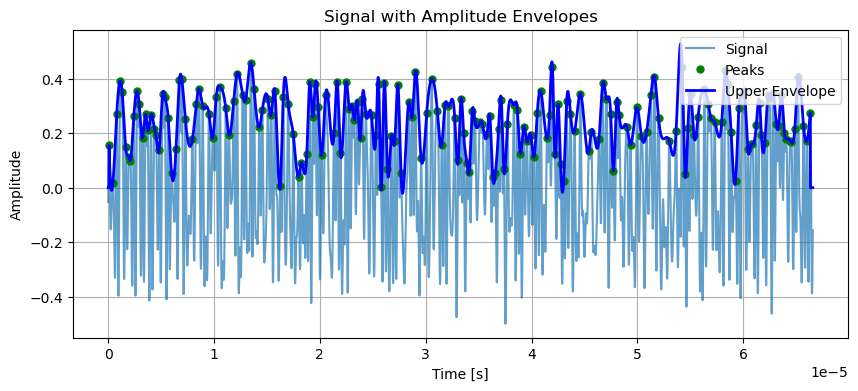

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

class EnvelopeDetector:
    def __init__(self, signal, sample_rate):
        self.signal = signal
        self.sample_rate = sample_rate

    def Inverse_Fourrier_transform(self):
        """
        Assuming the signal is in the frequency domain, this method would return
        the signal in the time domain. For now, it's just returning the original signal
        if the data is already in the time domain.
        """
        # For now, returning the original signal (if already in time domain)
        return self.signal

    def Get_envelope(self):
        """
        Calculates the envelope of the interpolated data (upper and lower envelopes).
        """
        # Apply the inverse Fourier transform (if needed)
        x_long = self.Inverse_Fourrier_transform()
        
        # Find peaks and troughs (local maxima and minima)
        peaks, _ = find_peaks(x_long.squeeze(), height=0)  # Peaks (local maxima)
        troughs, _ = find_peaks(-x_long.squeeze())         # Troughs (local minima)
        
        # Interpolation using cubic splines for upper and lower envelopes
        u_p = interp1d(peaks, x_long.squeeze()[peaks], kind='cubic', bounds_error=False, fill_value=0.0)
        l_p = interp1d(troughs, x_long.squeeze()[troughs], kind='cubic', bounds_error=False, fill_value=0.0)
        
        # Compute the upper and lower envelopes
        Upper_envelope = [u_p(i) for i in range(x_long.shape[0])]
        Lower_envelope = [l_p(i) for i in range(x_long.shape[0])]
        
        return peaks, troughs, Upper_envelope, Lower_envelope

# Example: Assuming 'data' is already your signal loaded from a file or other source
# For example, data could be loaded like this:
# data = np.fromfile("/path/to/your/datafile.dat", dtype=np.float32)

sample_rate = 50e6  # Example: 50 MHz sampling rate (replace with your actual sampling rate)
# Make sure 'data' is loaded into the 'data' variable.

# Initialize the EnvelopeDetector object
detector = EnvelopeDetector(filtered_data_dft, sample_rate)

# Get the envelope (peaks, troughs, and envelopes)
peaks, troughs, Upper_envelope, Lower_envelope = detector.Get_envelope()

# Generate time axis for plotting (replace with actual time based on your signal and sample rate)
time = np.arange(0, len(filtered_data_dft)) / sample_rate

# Plot the signal and its amplitude envelopes
plt.figure(figsize=(10, 4))
plt.plot(time, filtered_data_dft, label='Signal', alpha=0.7)
plt.plot(time[peaks], filtered_data_dft[peaks], 'go', label='Peaks', markersize=5)  # Peaks in green
#plt.plot(time[troughs], data[troughs], 'ro', label='Troughs', markersize=5)  # Troughs in red
plt.plot(time, Upper_envelope, color='blue', label='Upper Envelope', linewidth=2)
#plt.plot(time, Lower_envelope, color='orange', label='Lower Envelope', linewidth=2)

# Set plot labels and title
plt.title("Signal with Amplitude Envelopes")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# Skewness, Kurtosis  & KDE plot of filtered data

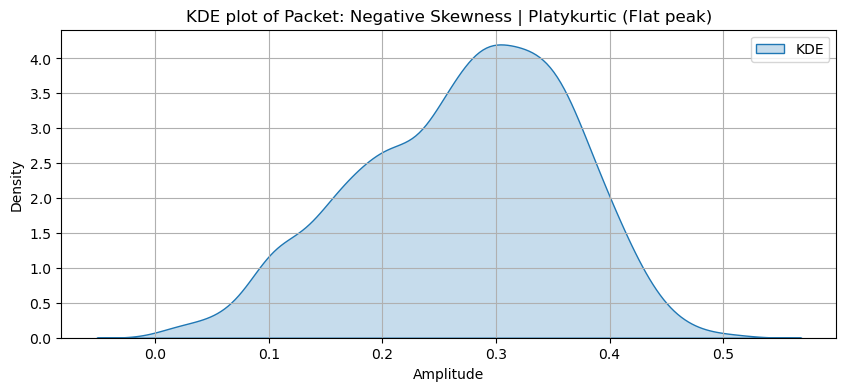

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate skewness
def moment_based_skew(distribution):
    n = len(distribution)
    mean = np.mean(distribution)
    std = np.std(distribution)

    # Divide the formula into two parts
    first_part = n / ((n - 1) * (n - 2))
    second_part = np.sum(((distribution - mean) / std) ** 3)

    skewness = first_part * second_part
    return skewness

# Function to calculate kurtosis
def moment_based_kurtosis(distribution):
    n = len(distribution)
    mean = np.mean(distribution)
    std = np.std(distribution)

    kurtosis = (1 / n) * np.sum(((distribution - mean) / std) ** 4) - 3
    return kurtosis



# Compute skewness and kurtosis
skewness = moment_based_skew(np.abs(filtered_data_dft))
kurtosis_value = moment_based_kurtosis(np.abs(filtered_data_dft))

# Determine skewness type
if skewness > 0:
    skewness_description = "Positive Skewness"
elif skewness < 0:
    skewness_description = "Negative Skewness"
else:
    skewness_description = "Symmetrical Distribution"

# Determine kurtosis type
if kurtosis_value > 3:
    kurtosis_description = "Leptokurtic (Sharp peak)"
elif kurtosis_value < 3:
    kurtosis_description = "Platykurtic (Flat peak)"
else:
    kurtosis_description = "Mesokurtic (Normal peak)"

# Plot the KDE for the current packet
plt.figure(figsize=(10, 4))

# Use the magnitude for KDE plotting
sns.kdeplot(np.abs(filtered_data_dft), label="KDE", fill=True)  # KDE for magnitude
plt.title(f"KDE plot of Packet: {skewness_description} | {kurtosis_description}")
plt.xlabel("Amplitude")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# Plot the resampled spectrogram of the filtered data

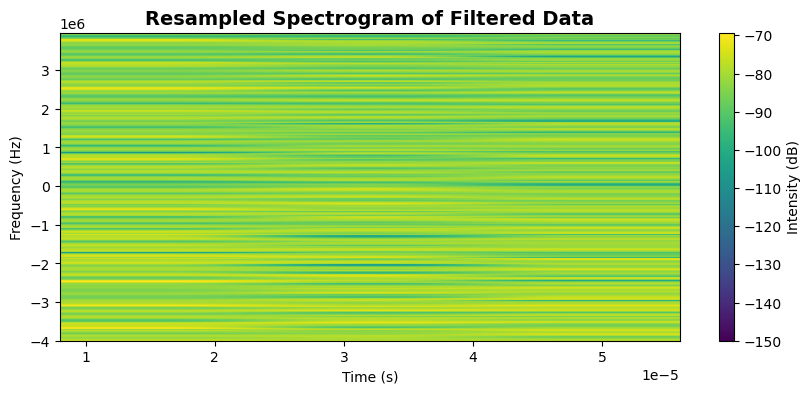

In [62]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

def plot_resampled_spectrogram(filtered_data_dft, P, Q, VMIN=-150):
    """
    Plot the resampled spectrogram of the filtered data.

    Parameters:
        filtered_data_dft (np.ndarray): The filtered data to plot the spectrogram for.
        P (float): The original sampling rate (Hz).
        Q (float): The resampled sampling rate (Hz).
        VMIN (float): Minimum color intensity in the spectrogram (default: -150 dB).
    """
    # Resample the filtered data to match the desired resampling rate
    resampled_data = scipy.signal.resample(filtered_data_dft, int(len(filtered_data_dft) * Q / P))

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    plt.specgram(resampled_data, scale='dB', Fs=Q, vmin=VMIN)
    plt.title('Resampled Spectrogram of Filtered Data', fontsize=14, fontweight='bold')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Intensity (dB)")
    plt.show()

# Example usage
P = 50e6  # Original sampling rate (50 MHz)
Q = 8e6  # Resampled sampling rate (10 MHz)
resampled_data=plot_resampled_spectrogram(filtered_data_dft, P, Q)


# Computes and plots the magnitude and phase spectrum of a resampled data using FFT

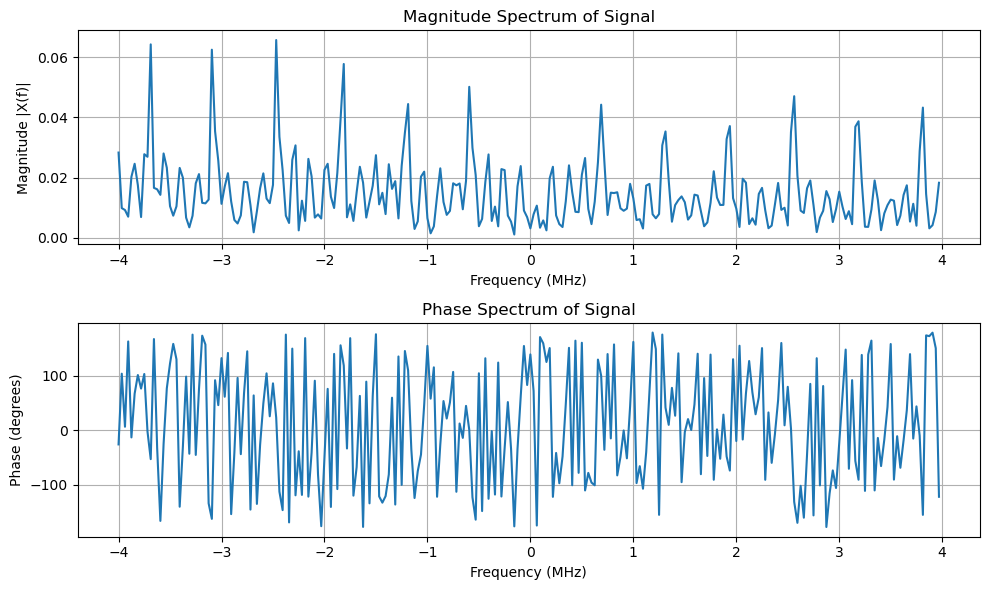

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def plot_magnitude_phase_spectrum(signal, sampling_rate=50e6, fft_size=1024):
    """
    Computes and plots the magnitude and phase spectrum of a signal using FFT.

    Parameters:
    - signal: np.ndarray, complex time-domain signal.
    - sampling_rate: float, sampling rate in Hz (default: 50e6).
    - fft_size: int, FFT size (default: 1024).
    """

    # Compute FFT with normalization and shift
    X = np.fft.fftshift(np.fft.fft(signal, fft_size)) / fft_size

    # Frequency axis setup
    df = sampling_rate / fft_size
    sample_index = np.arange(-fft_size // 2, fft_size // 2)
    f = sample_index * df / 1e6  # Convert Hz to MHz for plotting

    # Plot magnitude and phase
    plt.figure(figsize=(10, 6))

    # Magnitude spectrum
    plt.subplot(2, 1, 1)
    plt.plot(f, np.abs(X))
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Magnitude |X(f)|')
    plt.title('Magnitude Spectrum of Signal')
    plt.grid(True)

    # Phase spectrum
    plt.subplot(2, 1, 2)
    phase = np.angle(X, deg=True)
    plt.plot(f, phase)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Phase (degrees)')
    plt.title('Phase Spectrum of Signal')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage with resampled data
P = 50e6  # Original sampling rate (50 MHz)
Q = 8e6  # Resampled sampling rate (10 MHz)

# Assuming resampled_data is already obtained from plot_resampled_spectrogram function
resampled_data = scipy.signal.resample(filtered_data_dft, int(len(filtered_data_dft) * Q / P))

# Plot magnitude and phase spectrum for the resampled data
plot_magnitude_phase_spectrum(resampled_data, sampling_rate=Q, fft_size=256)


# Compute the Power Spectral Density (PSD) of the resampled data using Welch's method.

Mean PSD Value: 2.60e-09 V^2/Hz


/tmp/ipykernel_143085/4219973945.py:23: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = hamming(len(resampled_data))


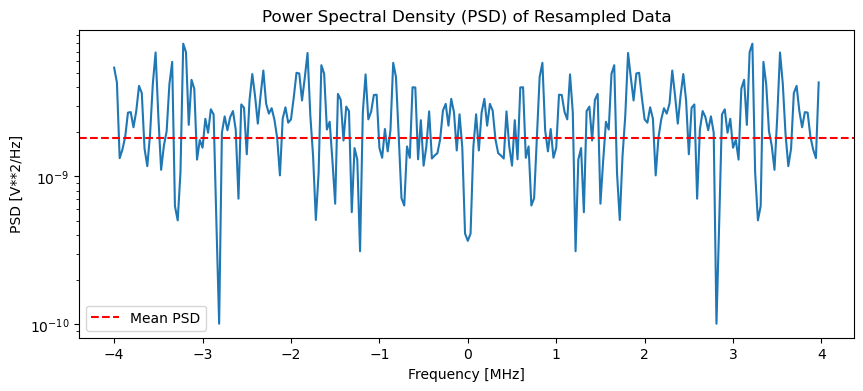

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, hamming

def compute_psd(resampled_data, fs, nfft_welch=256):
    """
    Compute the Power Spectral Density (PSD) of the resampled data using Welch's method.
    
    Parameters:
        resampled_data (np.ndarray): The resampled signal data.
        fs (float): Sampling frequency in Hz.
        nfft_welch (int): Number of FFT points for Welch's method (default is 1024).
        
    Returns:
        None
    """
    # Ensure data length is sufficient for Welch's method
    if len(resampled_data) < nfft_welch:
        print("Insufficient data length for Welch's method")
        return

    # Apply Hamming window
    window = hamming(len(resampled_data))
    resampled_data_windowed = np.real(resampled_data) * window  # Using the real part of the resampled data

    # Calculate PSD using Welch's method
    f, Pxx_den = welch(
        resampled_data_windowed, fs=fs, nperseg=nfft_welch, return_onesided=False
    )

    # Shift frequency and PSD for negative frequencies
    Pxx_den_shifted = np.fft.fftshift(Pxx_den)
    f_shifted = np.fft.fftshift(f)

    # Calculate the mean PSD value
    mean_psd_value = np.mean(Pxx_den_shifted)
    print(f"Mean PSD Value: {mean_psd_value:.2e} V^2/Hz")

    # Plot the PSD
    plt.figure(figsize=(10, 4))
    plt.semilogy(f_shifted / 1e6, Pxx_den_shifted)  # Convert frequency to MHz
    plt.axhline(0.7 * Pxx_den_shifted.mean(), color='r', linestyle='--', label="Mean PSD")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD [V**2/Hz]")
    plt.title("Power Spectral Density (PSD) of Resampled Data")
    plt.legend()
    plt.show()

# Example usage
# Assuming 'resampled_data' is the resampled signal data (after resampling the filtered data)
# and 'fs' is the sampling frequency for the resampled data
compute_psd(resampled_data, Q)


# Comute SNR of resampled data

In [71]:
import numpy as np

def calculate_snr_mu_sigma_full(resampled_data):
    """
    Calculate SNR using the ratio of mean to standard deviation over the full resampled data.

    Parameters:
    resampled_data (np.array): Complex or real signal

    Returns:
    float: SNR in dB
    """
    magnitudes = np.abs(resampled_data)  # Use magnitude if signal is complex

    mu = np.mean(magnitudes)
    sigma = np.std(magnitudes)

    if sigma == 0:
        return np.inf

    snr_linear = mu / sigma
    snr_db = 20 * np.log10(snr_linear)

    print(f"Mean (μ): {mu:.4e}")
    print(f"Std Dev (σ): {sigma:.4e}")
    print(f"SNR (μ/σ): {snr_linear:.2f}")
    print(f"SNR (dB): {snr_db:.2f} dB")

    return snr_db
snr_db = calculate_snr_mu_sigma_full(resampled_data)


Mean (μ): 2.7240e-01
Std Dev (σ): 9.2359e-02
SNR (μ/σ): 2.95
SNR (dB): 9.39 dB


# Skewness, Kurtosis and KDE plot of resampled data

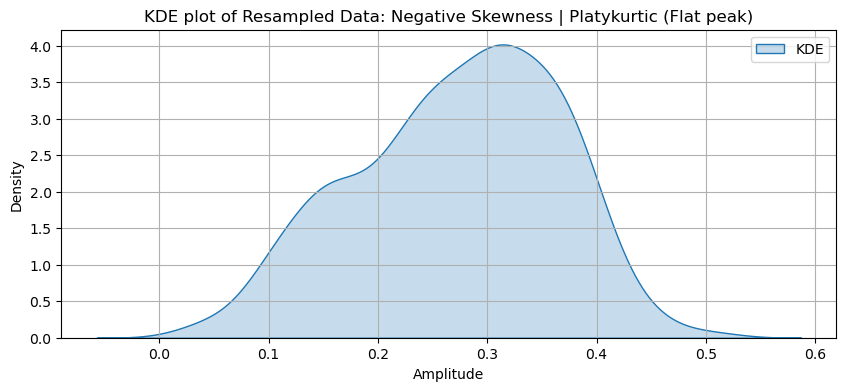

skewness: -0.2969966125472755
Kurtosis: -0.5657438447673386


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate skewness
def moment_based_skew(distribution):
    n = len(distribution)
    mean = np.mean(distribution)
    std = np.std(distribution)

    # Divide the formula into two parts
    first_part = n / ((n - 1) * (n - 2))
    second_part = np.sum(((distribution - mean) / std) ** 3)

    skewness = first_part * second_part
    return skewness

# Function to calculate kurtosis
def moment_based_kurtosis(distribution):
    n = len(distribution)
    mean = np.mean(distribution)
    std = np.std(distribution)

    kurtosis = (1 / n) * np.sum(((distribution - mean) / std) ** 4) - 3
    return kurtosis

# Compute skewness and kurtosis for resampled data
skewness = moment_based_skew(np.abs(resampled_data))
kurtosis_value = moment_based_kurtosis(np.abs(resampled_data))

# Determine skewness type
if skewness > 0:
    skewness_description = "Positive Skewness"
elif skewness < 0:
    skewness_description = "Negative Skewness"
else:
    skewness_description = "Symmetrical Distribution"

# Determine kurtosis type
if kurtosis_value > 3:
    kurtosis_description = "Leptokurtic (Sharp peak)"
elif kurtosis_value < 3:
    kurtosis_description = "Platykurtic (Flat peak)"
else:
    kurtosis_description = "Mesokurtic (Normal peak)"

# Plot the KDE for the current packet
plt.figure(figsize=(10, 4))

# Use the magnitude of the resampled data for KDE plotting
sns.kdeplot(np.abs(resampled_data), label="KDE", fill=True)  # KDE for magnitude
plt.title(f"KDE plot of Resampled Data: {skewness_description} | {kurtosis_description}")
plt.xlabel("Amplitude")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("skewness:",skewness)
print("Kurtosis:",kurtosis_value)


# Feature extraction of resampled data

In [75]:
FEATURES = ['MIN', 'MAX', 'MEAN', 'RMS', 'VAR', 'STD', 'POWER', 'PEAK', 'P2P', 'CREST FACTOR', 
            'SKEW', 'KURTOSIS', 'MAX_f', 'SUM_f', 'MEAN_f', 'VAR_f', 'PEAK_f', 'SKEW_f', 'KURTOSIS_f']

def features_extraction(df): 
    # Initialize feature lists
    Min = []; Max = []; Mean = []; Rms = []; Var = []; Std = []; Power = []; Peak = []; Skew = []; Kurtosis = []; 
    P2p = []; CrestFactor = []; FormFactor = []; PulseIndicator = [];
    Max_f = []; Sum_f = []; Mean_f = []; Var_f = []; Peak_f = []; Skew_f = []; Kurtosis_f = [];
    
    # Extract data directly from df (assuming df is a series or array-like object containing the signal)
    X = df.values  # Directly use the values from the dataframe
    
    ## TIME DOMAIN ##
    Min.append(np.min(X))
    Max.append(np.max(X))
    Mean.append(np.mean(X))
    Rms.append(np.sqrt(np.mean(X**2)))
    Var.append(np.var(X))
    Std.append(np.std(X))
    Power.append(np.mean(X**2))
    Peak.append(np.max(np.abs(X)))
    P2p.append(np.ptp(X))  # Peak-to-Peak
    CrestFactor.append(np.max(np.abs(X)) / np.sqrt(np.mean(X**2)))
    Skew.append(stats.skew(X))
    Kurtosis.append(stats.kurtosis(X))
    FormFactor.append(np.sqrt(np.mean(X**2)) / np.mean(X))  # Form Factor
    PulseIndicator.append(np.max(np.abs(X)) / np.mean(X))  # Pulse Indicator
    
    ## FREQ DOMAIN ##
    ft = fft(X)  # Fourier transform of the signal
    S = np.abs(ft)**2 / len(X)  # Power spectral density (normalized)
    
    Max_f.append(np.max(S))
    Sum_f.append(np.sum(S))
    Mean_f.append(np.mean(S))
    Var_f.append(np.var(S))
    Peak_f.append(np.max(np.abs(S)))
    Skew_f.append(stats.skew(S))
    Kurtosis_f.append(stats.kurtosis(S))
    
    # Print each feature individually
    print("# TIME DOMAIN")
    print(f"Minimum amplitude of the signal: {Min[0]}")
    print(f"Maximum amplitude of the signal: {Max[0]}")
    print(f"Mean or Average Value of signal: {Mean[0]}")
    print(f"Root mean square of the signal: {Rms[0]}")
    print(f"Variance of the signal's amplitude: {Var[0]}")
    print(f"Standard Deviation of the signal's amplitude: {Std[0]}")
    print(f"Average power of the signal: {Power[0]}")
    print(f"Peak amplitude of the signal: {Peak[0]}")
    print(f"Peak-to-Peak amplitude of the signal: {P2p[0]}")
    print(f"Crest factor of the signal: {CrestFactor[0]}")
    print(f"Skewness of the signal's amplitude distribution: {Skew[0]}")
    print(f"Kurtosis of the signal's amplitude distribution: {Kurtosis[0]}")

    print("# FREQUENCY DOMAIN")
    print(f"Maximum frequency component power: {Max_f[0]}")
    print(f"Total power in the frequency spectrum: {Sum_f[0]}")
    print(f"Average power in the frequency spectrum: {Mean_f[0]}")
    print(f"Frequency domain variance: {Var_f[0]}")
    print(f"Peak value of the frequency spectrum.: {Peak_f[0]}")
    print(f"Skewness of the frequency spectrum: {Skew_f[0]}")
    print(f"Kurtosis of the frequency spectrum: {Kurtosis_f[0]}")

# Example usage with signal data directly in df
 # Example signal data (replace with your actual signal data)
df = pd.DataFrame(np.abs(resampled_data))  # Convert to DataFrame if needed

# Extract and print features
features_extraction(df)


# TIME DOMAIN
Minimum amplitude of the signal: 0.021782099073854488
Maximum amplitude of the signal: 0.5079961241051527
Mean or Average Value of signal: 0.27239749823646875
Root mean square of the signal: 0.2876291795479241
Variance of the signal's amplitude: 0.008530147881924985
Standard Deviation of the signal's amplitude: 0.09235879969946006
Average power of the signal: 0.08273054492741197
Peak amplitude of the signal: 0.5079961241051527
Peak-to-Peak amplitude of the signal: 0.48621402503129824
Crest factor of the signal: 1.7661494737897814
Skewness of the signal's amplitude distribution: [-0.29532392]
Kurtosis of the signal's amplitude distribution: [-0.56574384]
# FREQUENCY DOMAIN
Maximum frequency component power: 0.00048507530471025883
Total power in the frequency spectrum: 0.08273054492741197
Average power in the frequency spectrum: 0.00015550854309663903
Frequency domain variance: 8.418409626065786e-09
Peak value of the frequency spectrum.: 0.00048507530471025883
Skewness of t

# Envelope detector of resampled data

/home/sandeep/.local/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


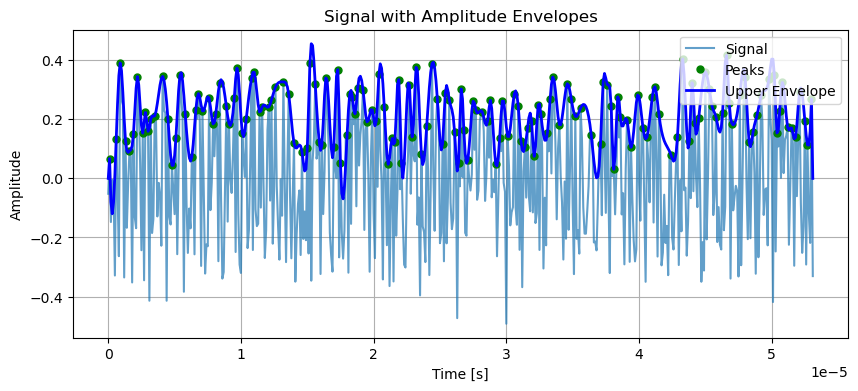

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

class EnvelopeDetector:
    def __init__(self, signal, sample_rate):
        self.signal = signal
        self.sample_rate = sample_rate

    def Inverse_Fourrier_transform(self):
        """
        Assuming the signal is in the frequency domain, this method would return
        the signal in the time domain. For now, it's just returning the original signal
        if the data is already in the time domain.
        """
        # For now, returning the original signal (if already in time domain)
        return self.signal

    def Get_envelope(self):
        """
        Calculates the envelope of the interpolated data (upper and lower envelopes).
        """
        # Apply the inverse Fourier transform (if needed)
        x_long = self.Inverse_Fourrier_transform()
        
        # Find peaks and troughs (local maxima and minima)
        peaks, _ = find_peaks(x_long.squeeze(), height=0)  # Peaks (local maxima)
        troughs, _ = find_peaks(-x_long.squeeze())         # Troughs (local minima)
        
        # Interpolation using cubic splines for upper and lower envelopes
        u_p = interp1d(peaks, x_long.squeeze()[peaks], kind='cubic', bounds_error=False, fill_value=0.0)
        l_p = interp1d(troughs, x_long.squeeze()[troughs], kind='cubic', bounds_error=False, fill_value=0.0)
        
        # Compute the upper and lower envelopes
        Upper_envelope = [u_p(i) for i in range(x_long.shape[0])]
        Lower_envelope = [l_p(i) for i in range(x_long.shape[0])]
        
        return peaks, troughs, Upper_envelope, Lower_envelope

# Example: Assuming 'data' is already your signal loaded from a file or other source
# For example, data could be loaded like this:
# data = np.fromfile("/path/to/your/datafile.dat", dtype=np.float32)

sample_rate = 10e6  # 10 MHz sampling rate (updated)
# Make sure 'resampled_data' is loaded into the 'resampled_data' variable.

# Initialize the EnvelopeDetector object
detector = EnvelopeDetector(resampled_data, sample_rate)

# Get the envelope (peaks, troughs, and envelopes)
peaks, troughs, Upper_envelope, Lower_envelope = detector.Get_envelope()

# Generate time axis for plotting (replace with actual time based on your signal and sample rate)
time = np.arange(0, len(resampled_data)) / sample_rate

# Plot the signal and its amplitude envelopes
plt.figure(figsize=(10, 4))
plt.plot(time, resampled_data, label='Signal', alpha=0.7)
plt.plot(time[peaks], resampled_data[peaks], 'go', label='Peaks', markersize=5)  # Peaks in green
#plt.plot(time[troughs], resampled_data[troughs], 'ro', label='Troughs', markersize=5)  # Troughs in red
plt.plot(time, Upper_envelope, color='blue', label='Upper Envelope', linewidth=2)
#plt.plot(time, Lower_envelope, color='orange', label='Lower Envelope', linewidth=2)

# Set plot labels and title
plt.title("Signal with Amplitude Envelopes")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
